In [1]:
import math
import io
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
import scipy.stats
import scipy.optimize
import scipy.spatial

Missing colon in file PosixPath('/home/mz/.config/matplotlib/stylelib/scientific.mplstyle'), line 15 ("                               'fc4f30', ")
Missing colon in file PosixPath('/home/mz/.config/matplotlib/stylelib/scientific.mplstyle'), line 16 ("                               'e5ae38',")
Missing colon in file PosixPath('/home/mz/.config/matplotlib/stylelib/scientific.mplstyle'), line 17 ("                               '6d904f',")
Missing colon in file PosixPath('/home/mz/.config/matplotlib/stylelib/scientific.mplstyle'), line 18 ("                               '8b8b8b',")
Missing colon in file PosixPath('/home/mz/.config/matplotlib/stylelib/scientific.mplstyle'), line 19 ("                               '810f7c'])")
Bad value in file PosixPath('/home/mz/.config/matplotlib/stylelib/scientific.mplstyle'), line 14 ("axes.prop_cycle: cycler(color=['008fd5', "): Key axes.prop_cycle: 'cycler(color=['008fd5',' is not a valid cycler construction: unexpected EOF while parsing (<unknown>, 

# confidence intervals (CI)
- range between lower and upper bound
- "there is a 95% probability that, in the future, the true value of the population parameter lies within the bounds of the CI"
- or "we are 95% confident that the CI contains the true value of the population parameter"
- over many similar experiments

In [2]:
poll =  pd.read_csv('data/poll.csv')

In [3]:
poll.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   vote    1000 non-null   object
dtypes: object(1)
memory usage: 7.9+ KB


In [4]:
poll.head()

,vote
0,Brown
1,Green
2,Brown
3,Brown
4,Brown


In [5]:
# Brown seems to be winning but this could due to sampling variablity
poll.vote.value_counts(normalize=True)

Brown    0.511
Green    0.489
Name: vote, dtype: float64

In [11]:
#  to study the sampling distribution of the proportion
# we wish to understand what range of different samples we may get for the same population
# we can do this by simulation of  a poll that reconstructs the original poll circumstances 
# n=1000 & with probability p votes for Brown 
# random.rand returns value in [0, 1]
def sample(brown, n=1000):
    return pd.DataFrame({'vote': np.where(np.random.rand(1000) < brown, 'Brown', 'Green')})

In [14]:
# one possible sample
s = sample(0.51, n=1000)

In [15]:
# since it is a random sample the ratio of votes for Brown is not exactly p=0.51 
# but somewhere around the given p
s.vote.value_counts(normalize=True)

Brown    0.52
Green    0.48
Name: vote, dtype: float64

In [16]:
# a df with the ratios of votes for Brown/Green of 1000 samples with a propability of 0.51 for Brown 
dist = pd.DataFrame([sample(0.51).vote.value_counts(normalize=True) for i in range (1000)])

In [19]:
len(dist)
dist.head()

,Brown,Green
vote,0.505,0.495
vote,0.519,0.481
vote,0.494,0.506
vote,0.485,0.515
vote,0.501,0.499


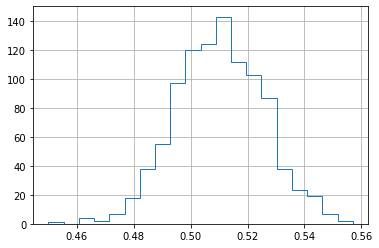

In [45]:
# dist of poll results for Brown in 1000 polls
dist.Brown.hist(histtype='step', bins=20);

In [8]:
# function for 1000 polls with 1000 votes
def samplingdist(brown, n=1000):
    return pd.DataFrame([sample(brown, n).vote.value_counts(normalize=True) for i in range(1000)])

In [9]:
# returns the lower and upper bound of the 95% CI
def quantiles(brown, n=1000):
    dist = samplingdist(brown, n)
    return  dist.Brown.quantile(0.025), dist.Brown.quantile(0.975)

In [29]:
# confidence interval CI of 1000 samples of polls
# in every poll n=1000 votes were given, the observed probabiliy for Brown was  0.51
quantiles(0.50)

(0.469, 0.533)

In [57]:
# 0.51 is still on the upper end of the CI
# .51 would show up in a 95% CI even if the probability of votes for Brown was .48
quantiles(0.48)

(0.45, 0.512)

In [58]:
# if the probability of votes for Brown was .54
# .51 could be a possible outcome in the 95% CI
quantiles(0.54)

(0.51, 0.572)

- thus for an observed sample of true proportion of 0.51
and a  sample size of 1000  the 95% CI for the true population fct.
lies between 0.48 and 0.54 
- Critical values of the CI = [0.48; 0.54]
- this can be expressed as the Estimate = 0.51 +/- 0.03 (at 95% confidence)
- where 0.51 is the point estimate and 0.03 is the margin of error
- The **margin of error** is a statistic expressing the amount of random sampling error in the results of a survey. 
- The larger the margin of error, the less confidence one should have that a poll result would reflect the result of a census of the entire population. 

In [12]:
# bigger sample for more precision
dist2 = samplingdist(0.50, 1000000)

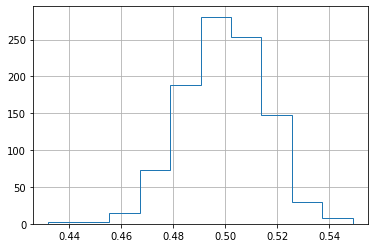

In [13]:
# the margin of error (z*std) should shrink with the sample size
dist2.Brown.hist(histtype='step');

In [17]:
# qunatiles(0.50, 1000) = (0.469, 0.533)
quantiles(0.50, 1000000)

(0.469, 0.531)

In [88]:
# the margin of error improves with the sqrt(number of samples)
largepoll = pd.read_csv('data/poll-larger.csv')

In [91]:
largepoll.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   vote    10000 non-null  object
dtypes: object(1)
memory usage: 78.2+ KB


In [89]:
largepoll.vote.value_counts(normalize=True)

Green    0.5181
Brown    0.4819
Name: vote, dtype: float64

# Bootstrapping
Bootstrap: estimating the sampling distribution of a statistic, or of model parameters, by drawing additional samples, with replacement, from the sample itself, and recalculate the statistic or model for each resample.

Conceptually, you can imagine the bootstrap as replicating the original sample thousands or millions of times so that you have a hypothetical population that embodies all the knowledge from your original sample (it’s just larger). You can then draw samples from this hypothetical population for the purpose of estimating a sampling distribution.

In [6]:
pop = pd.read_csv('data/grades.csv')

In [7]:
pop.head()

,grade
0,3.648651
1,5.959915
2,7.387370
3,4.047515
4,2.846912


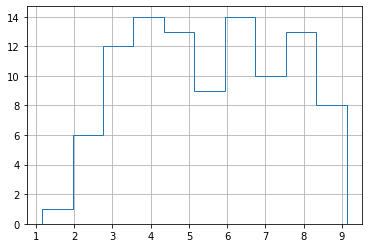

In [10]:
# no clear pattern is recognizable
pop.grade.hist(histtype='step');

In [100]:
# we have a sample mean but what can be said about the true mean
# we can't build a CI over the true distribution bc. we do not know how to describe the dist.
pop.describe()

,grade
count,100.000000
mean,5.508561
std,1.984988
min,1.160899
25%,3.921372
50%,5.688527
75%,7.272162
max,9.120705


In [102]:
# if we draw samples from our sample with replacement
# we find a mean that is a little different from the one in the original sample
pop.sample(100, replace=True).describe()

,grade
count,100.000000
mean,5.761000
std,1.863729
min,1.983167
25%,4.262308
50%,5.949652
75%,7.387370
max,8.888042


In [103]:
# we collect the means of 1000 samples from the original sample
bootstrap = pd.DataFrame({'meangrade':[pop.sample(100, replace=True).grade.mean() for i in range(1000)]})

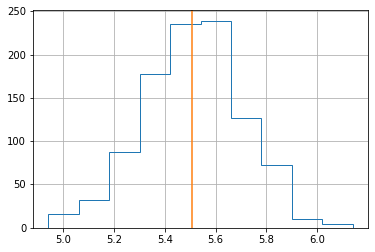

In [108]:
# distribution of means from 1000 bootstraped samples
bootstrap.meangrade.hist(histtype='step');
plt.axvline(pop.grade.mean(), color='C1');

In [110]:
# 95% of means are in the range of ...
bootstrap.meangrade.quantile(0.025), bootstrap.meangrade.quantile(0.975)

(5.12382181205314, 5.86668380437227)

- we found critical values for the CI of [5.123, 5.867]
- now we can retain the distribution for which the original sample was drawn and see if the CI is accurate

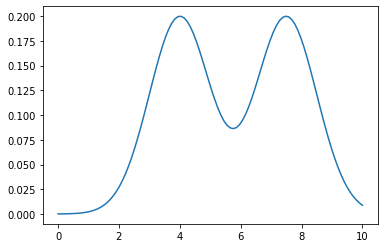

In [111]:
# bimodel distribution
n1 = scipy.stats.norm(7.5, 1)
n2 = scipy.stats.norm(4, 1)

x =np.linspace(0, 10, 100)
plt.plot(x, 0.5*n1.pdf(x) + 0.5*n2.pdf(x))

In [113]:
# function to draw grades between 0 and 10 from the bimodel distribution
def draw():
    while True:
        # draw a random sample from one of the distributions with 50/50 chance
        v = n1.rvs() if np.random.rand() < 0.5 else n2.rvs()
        # return only values between 0 and 10
        if 0 <= v <= 10:
            return v

In [114]:
draw()

3.696129087208373

In [115]:
# create a data set by calling the fct repeatedly
def dataset (n=100):
    return pd.DataFrame({'grade': [draw() for i in range(n)]})

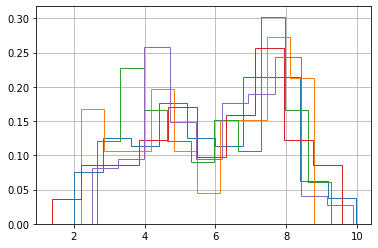

In [121]:
# plot a few different data sets
for i in range(5):
    dataset(100).grade.hist(histtype='step', density=True)

In [122]:
# means of 1000 data sets
means = pd.DataFrame({'meangrade': [dataset(100).grade.mean() for i in range(1000)]})

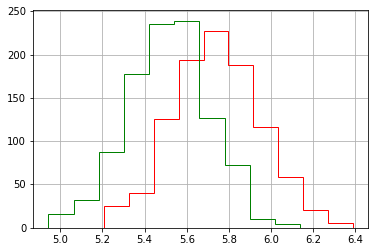

In [129]:
# the reconstruction of the original distribution  
# and the bootstrapped distribution have displaced means but the spread is comparable
means.meangrade.hist(histtype='step', color='red');
bootstrap.meangrade.hist(histtype='step',color='green' );

# Hypothesis Testing
- cholera outbreak in Soho - Jon Snow 

In [139]:
pumps = pd.read_csv('data/pumps.csv')

In [140]:
pumps

,lat,lon,x,y
0,51.513341,-0.136668,0.000000,0.000000
1,51.513876,-0.139586,-0.201858,0.059469
2,51.514906,-0.139671,-0.207738,0.173961
3,51.512354,-0.131630,0.348513,-0.109712
4,51.512139,-0.133594,0.212650,-0.133611
5,51.511542,-0.135919,0.051813,-0.199972
6,51.510019,-0.133962,0.187193,-0.369265
7,51.511295,-0.138199,-0.105910,-0.227428


In [132]:
cholera = pd.read_csv('data/cholera.csv')

In [137]:
cholera.loc[0::20]

,deaths,lat,lon,x,y,closest
0,3,51.513418,-0.137930,-0.087301,0.008559,0
20,2,51.513441,-0.138762,-0.144856,0.011116,1
40,2,51.513025,-0.139036,-0.163811,-0.035126,1
60,1,51.512765,-0.137533,-0.059838,-0.064027,0
80,1,51.512782,-0.136819,-0.010446,-0.062137,0
100,4,51.512250,-0.135394,0.088131,-0.121273,5
120,1,51.513238,-0.134594,0.143473,-0.011449,4
140,1,51.512585,-0.134793,0.129707,-0.084035,4
160,1,51.514065,-0.134364,0.159384,0.080478,0
180,1,51.515149,-0.135395,0.088062,0.200973,0


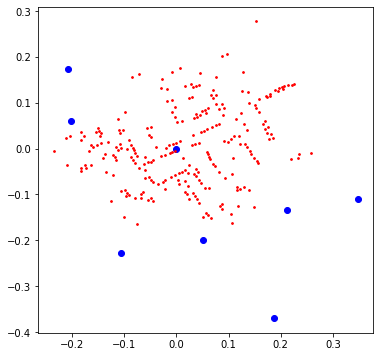

In [143]:
plt.figure(figsize=(6, 6))
plt.scatter(pumps.x, pumps.y, color='b');
plt.scatter(cholera.x, cholera.y, color='r', s=3);

In [144]:
img = matplotlib.image.imread('data/london.png')

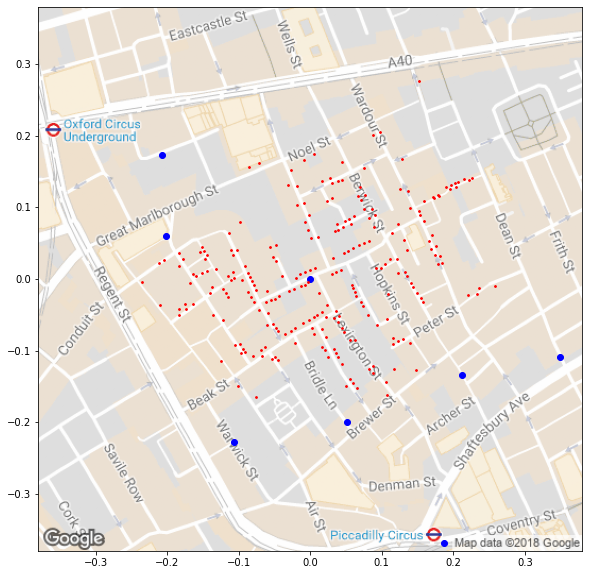

In [147]:
plt.figure(figsize=(10,10))
plt.imshow(img, extent =[-0.38, 0.38, -0.38, 0.38]); # the image covers 7,6 km^2
plt.scatter(pumps.x, pumps.y, color='b');
plt.scatter(cholera.x, cholera.y, color='r', s=3);

In [148]:
# pump clostest to the dead
cholera.closest.value_counts()

0    171
1     36
4     19
5     13
7      9
2      2
Name: closest, dtype: int64

In [150]:
# count of dead people by pump
cholera.groupby('closest').deaths.sum()

closest
0    340
1     65
2      5
4     40
5     27
7     12
Name: deaths, dtype: int64

- if we assume the population density is much higher in the area around pump 0
- we expect more death in this area. In this fct we take only the pumps with high dead counts
- and select each death randomly, proportionally to the population of the area

In [175]:
def simulate(n):
    return pd.DataFrame({'closest': np.random.choice([0, 1, 4, 5], size=n, p=[0.65, 0.15, 0.10, 0.10])})

In [176]:
# total number of deaths is 489
simulate(489).closest.value_counts()

0    318
1     71
4     57
5     43
Name: closest, dtype: int64

In [177]:
# sampling distribution of the number of death in area 0
sampling = pd.DataFrame({'counts' : [simulate(489).closest.value_counts()[0] for i in range (10000)]})

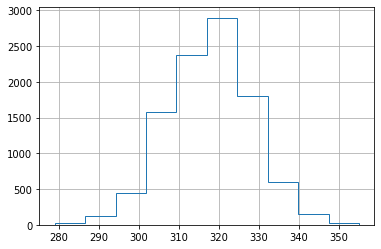

In [178]:
# assuming death are simply proportion
sampling.counts.hist(histtype='step');

- the distribution was created under the Nullhypothesis  that pumps have nothing to do with cholera 
-  and cholera cases occure simple proportionally to the population density
- we can now compare this distribution with the observed data
- in the original data we observed 340 death around pump 0, how likely is this value under the Nullhypothesis?

# p-value

In [184]:
# under what quantile do we find the value of 340?
scipy.stats.percentileofscore(sampling.counts, 340)

98.48

In [187]:
100 - 98.48

1.519999999999996

- 340  seems to pretty extrem, under the Null we would not expect this value to occure 
- we would expect it only 1.51% of times 
- this is known as the p-value
- the smaller p the more strongly we can reject the Nullhypothesis

relationship between hypothesis testing and CI
- **CI** gives us a range of possible values and an estimate of the precision for our parameter value.
- **Hypothesis tests tells** us how confident we are in drawing conclusions about the population parameter from our sample.
- If the $\mu_0$ falls within the CI, then the p-value > 5%. 
- If the $\mu_0$ falls outside the CI then the p-value <  5%.
- When $\mu_0$ is included in our CI we'll see no difference between our sample and the population parameter. 

In [188]:
poll = pd.read_csv('data/poll.csv')

In [189]:
# H_0: Green wins the election, Brown fraction must be 0.5 or lower
#  is 0.511 a extreme resut if H_0 holds?
poll.vote.value_counts(normalize=True)

Brown    0.511
Green    0.489
Name: vote, dtype: float64

In [195]:
def sample(brown, n=1000):
   return pd.DataFrame({'vote': np.where(np.random.rand(n)< brown, 'Brown', 'Green')})

In [196]:
dist = pd.DataFrame({'Brown': [sample(0.50, 1000).vote.value_counts(normalize=True)['Brown'] for i in range(10000)]})

In [197]:
dist.head()

,Brown
0,0.504
1,0.478
2,0.460
3,0.492
4,0.510


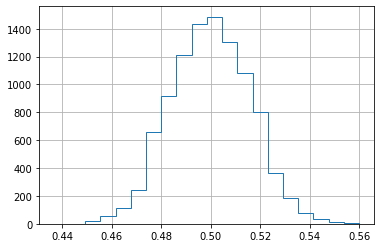

In [199]:
# 0.511 is not an extrem value according to the histogram of the distribution
dist.Brown.hist(histtype='step', bins=20);

In [201]:
# the p-value is very large we've up to 24.5% probability to encounter 0.511 and larger under the H_0
100 - scipy.stats.percentileofscore(dist.Brown, 0.511)

24.549999999999997

In [2]:
# with the larger sample we can test if Brown wins or ties the vote, since Green seems to have the majority
# H_0 and H_1 are complementary
largerpoll = pd.read_csv('data/poll-larger.csv')

In [3]:
largerpoll.vote.value_counts(normalize=True)

Green    0.5181
Brown    0.4819
Name: vote, dtype: float64

In [205]:
dist = pd.DataFrame({'Green': [sample(0.50, 10000).vote.value_counts(normalize=True)['Green'] for i in range(1000)]})

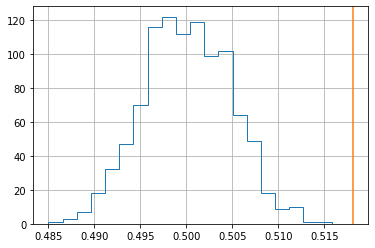

In [210]:
# here the Null seems to be very unlikely
# 0,5181 for Brown is not even in then assumed distribution 
dist.Green.hist(histtype='step', bins=20);
plt.axvline(0.5181, c='C1');

# major grades

In [ ]:
pop = pd.read_csv('data/grades.csv')

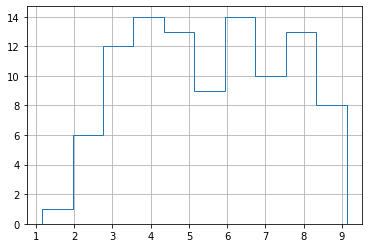

In [214]:
pop.grade.hist(histtype='step');

In [212]:
# percentage of people who gave the major a 5 or less
scipy.stats.percentileofscore(pop.grade, 5)

43.0

In [4]:
# bootstrap distribution of 1000 percentile scores
bootstrap = pd.DataFrame({'passing': [scipy.stats.percentileofscore(pop.sample(100, replace=True).grade, 5) for i in range(1000)]})

NameError: name 'pop' is not defined

In [1]:
bootstrap.passing.hist(histtype='step', bins = 20);

NameError: name 'bootstrap' is not defined

In [219]:
# the 95% CI [34, 53] percent for the percentage of  citizens for whom the mayor is failing
# overall the mayor might very likely have the support of the citizens
bootstrap.passing.quantile(0.025), bootstrap.passing.quantile(0.975)

(34.0, 53.0)